<a href="https://colab.research.google.com/github/gsurend4/BackPropogration/blob/main/Intro_to_BackPropogation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
class Value:
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda : None # Setting up here just to handle the lead node
        self._op = _op
        self.label = label
        self.grad = 0 # Intially setting there is no Impact of this Variable to the Output Function (loss). ex : y = 5

    def __repr__(self):
        return (f'Value(data = {self.data})')

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # think as if you are going back from child to its parents

            self.grad = 1.0 * out.grad # Since sum operator is just a distributer
            other.grad = 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        out =  Value(self.data * other.data, (self, other), '*')

        def _backward():
            # think as if you are going back from child to its parents

            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        #tanh = e^x - e^-x / e^x + e^-x or tanh = (e2x − 1 / e2x +1) (There are many forms)
        t = (math.exp(self.data) - math.exp(-self.data)) / (math.exp(self.data) + math.exp(-self.data))
        out = Value(t, _children=(self, ) ,_op='tanh')

        def _backward():
            # dif tanh = 1 - tan**2
            local_gradient = (1 - t**2)
            self.grad = local_gradient * out.grad # Reverting to assignment

        out._backward = _backward

        return out

In [6]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10, label = 'c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd' # (a.__mul__(b)).__add__(c) Interally python call this way

f = Value(-2.0, label = 'f')

L = d * f; L.label = 'L'

L

Value(data = -8.0)

### graphviz (Visualization)

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

### Visualize

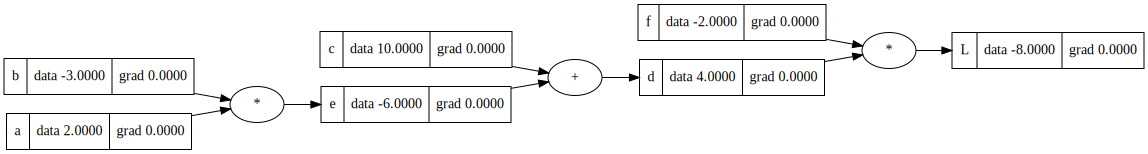

In [7]:
draw_dot(L)

In [ ]:
# Manually Setting the Gradients so that we can validate with data

L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
e.grad = -2.0
c.grad = -2.0
a.grad = 6.0
b.grad = -4.0

**Notes On Gradients**

1. dL/dL = 1

2. **Product Rule :**

    - dL/df = d  (L = f * d)
    - dL/dd = f  (L = f * d)

3. **Sum Rule :** (d = c + e)  based on sum rule differncing is always 1

    - dL/dc = f  (dL/dd * dd/dc)
    - Because dd/dc = 1 (Based on Sum rule)
    - f * 1 = f
    - **Sum function always acts as a Pass through. They act as a funnel through which they derivatives pass**
    - **It distributes all the derivates**

4. dL/db = a * f

    - Becuase dL/db = dL/dd * dd/c * dd/de * de/db
    - which is dL/db = f * 1 * 1 * a
    - a * f
    - Similarly `dL/da = b * f`


In [ ]:
# Testing Function

def lol():

    h = 0.001

    a = Value(2.0, label = 'a')
    b = Value(-3.0 , label = 'b')
    c = Value(10, label = 'c')

    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd' # (a.__mul__(b)).__add__(c) Interally python call this way

    f = Value(-2.0, label = 'f')

    L = d * f; L.label = 'L'

    L1 = L.data

    # --- Now we change 'a' slightly and recalculate L ---
    a = Value(2.0, label = 'a') # <--- Here's where we add 'h' to 'a'
    b = Value(-3.0 + h, label = 'b')
    c = Value(10, label = 'c')

    e = a*b; e.label = 'e';# e.data = e.data + h --> testing
    d = e + c; d.label = 'd'; #d.data = d.data + h -- Tesing

    f = Value(-2.0, label = 'f')

    L = d * f; L.label = 'L'

    L2 = L.data

    print('Derivative of L with respect to a:', (L2 - L1)/h)

lol()

#### Observation

- This derivative tells you how **sensitive the output L is to changes in the input a**. A derivative of approximately 6 means that if you increase `a` by a small amount, `L` will increase by approximately `6 times` that amount.

- differnectiaing `L with respect to L` which should give `1` ideally

- ex :   L1 = L.data ; L2 = L.data + h. Out = 1.0000

In [ ]:
a.data += 0.01 * a.grad # Adjusting the Input based on the sensitivity
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

print('a', a.data)
print('b', b.data)
print('c', c.data)
print('f', f.data)

e = a * b
d = c + e
L = f * d

print(L.data)

**Key Note :**

- The gradient tells you the sensitivity of the output (L) to changes in each input (a, b, c, f). By adjusting the inputs based on this sensitivity, you are making informed decisions about how to change them to achieve your optimization goal (maximizing or minimizing L).
- **Positive gradient:** If the gradient of L with respect to an input (say, a) is positive (a.grad > 0), it means that if you increase a, L will increase.

- **Negative gradient:** If the gradient of L with respect to an input (a) is negative (a.grad < 0), it means that if you increase a, L will decrease.

- Conclusion (L Loss Function Output):

    - **maximize** --> input.data += learning_rate * input.grad

    - **minimize** --> input.data -= learning_rate * input.grad



In [4]:
# tanh plot

import numpy as np
import matplotlib.pyplot as plt
import math

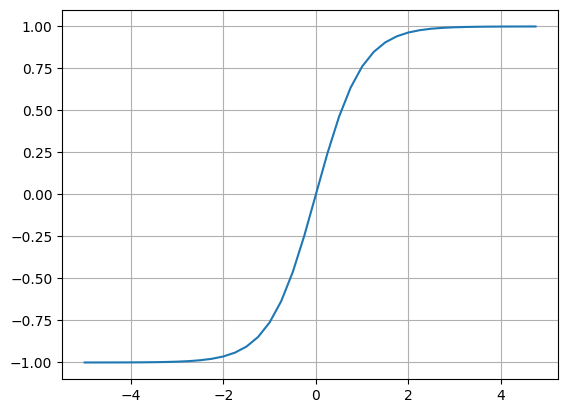

In [5]:
plt.plot(np.arange(-5,5,0.25), np.tanh(np.arange(-5,5,0.25)))

plt.grid()

## Single Neural Network example

**Tanh - Visualization**

Reference : https://www.geeksforgeeks.org/deep-learning/tanh-activation-in-neural-network/

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20250214171817652462/tanh.png" width=700>

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20250214175348702686/Derivative-of-Tanh-.png" width=700>

In [6]:
# Inputs x1 & x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1 & w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b1 = Value(6.8813735870195432, label = 'b1')

# Layer1
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

#Hidden layer calculation
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

#Hidden Layer + Bias
n = x1w1x2w2 + b1; n.label = 'n'

#Activation function (tanh)
o = n.tanh(); o.label = 'o'

o

Value(data = 0.7071067811865477)

In [ ]:
# calculating gradient Manually

o.grad = 1.0
n.grad = 1 - o.data**2
x1w1x2w2.grad = n.grad
b1.grad = n.grad
x2w2.grad =  x1w1x2w2.grad # + operators are distributers
x1w1.grad = x1w1x2w2.grad
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

# Local Derivative of a tanh
# do/dn = d(tanh)/dn --> 1 - tanh**2
# do/dn = 1 - o**2

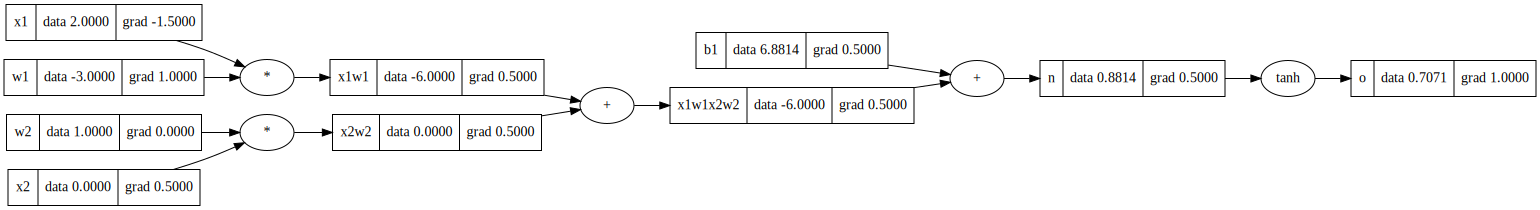

In [18]:
draw_dot(o)

**Important Note**

When you call the _backward() function on a Value object, its primary responsibility is to update the grad attribute of its parent(s) in the computation graph.

In [17]:
# Automating in finding the local gradient

o.grad = 1.0 # Since we need current notes gradient to update the parent (Chain rule)

o._backward()

n._backward()

x1w1x2w2._backward()

x1w1._backward()

x2w2._backward()